In [33]:
%reset -f
import matplotlib.pyplot as plt
import random

############################################################################################################

def grow_obstacles(object_edges, robot_size):
    expanded_edges = {}

    for obj_id, points in object_edges.items():
        P0 = (points[0][0] - robot_size, points[0][1] + robot_size)
        P1 = (points[1][0] + robot_size, points[1][1] + robot_size)
        P2 = (points[2][0] + robot_size, points[2][1] - robot_size)
        P3 = (points[3][0] - robot_size, points[3][1] - robot_size)
        expanded_edges[obj_id]= [P0, P1, P2, P3]
    return expanded_edges


#############################################################################################################
#From the list of point I need to establish which points are connected to each other.
#The points are connected if they don't cross a line connecting points from the same object.

#function that defines the orientation of three given points
def compute_orientation(p1,p2,p3):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    orientation_value = (y2-y1)*(x3-x2)-(y3-y2)*(x2-x1)
    # Check for collinear, clockwise, or counterclockwise orientation
    if orientation_value == 0:
        return 0  # Collinear
    elif orientation_value > 0:
        return -1  # Clockwise orientation
    else:
        return 1  # Counterclockwise orientation

#For 3 collinear points a,b,c, we search if point c lies on segment ab    
def onSegment(a, b, c): 
    xa, ya = a
    xb, yb = b
    xc, yc = c
    if ( (xc <= max(xa, xb)) and (xc >= min(xa, yb)) and 
           (yc <= max(ya, yb)) and (yc >= min(ya, yb))): 
        return True
    return False

#function that checks if two line segments intersect
def intersect(p1,q1,p2,q2):
    xp1, yp1 = p1
    xq1, yq1 = q1
    xp2, yp2 = p2
    xq2, yq2 = p2

    o1=compute_orientation(p1,q1,p2)
    o2=compute_orientation(p1,q1,q2)
    o3=compute_orientation(p2,q2,p1)
    o4=compute_orientation(p2,q2,q1)
    #If two points are equal 
    if p1==p2 or p1==q2 or q1==p2 or q1==q2:
        return False
    
    # General case
    if o1 != o2 and o3 != o4:
        return True
    
    # p1 , q1 and p2 are collinear and p2 lies on segment p1q1 
    if ((o1 == 0) and onSegment(p1, q1, p2)): 
        return True
  
    # p1 , q1 and q2 are collinear and q2 lies on segment p1q1 
    if ((o2 == 0) and onSegment(p1, q1, q2)): 
        return True
  
    # p2 , q2 and p1 are collinear and p1 lies on segment p2q2 
    if ((o3 == 0) and onSegment(p2, q2, p1)): 
        return True
  
    # p2 , q2 and q1 are collinear and q1 lies on segment p2q2 
    if ((o4 == 0) and onSegment(p2, q2, q1)): 
        return True
    return False 

#Give a name to avery point. Creates a dictionnary with names as key associated to point coordinates
def name2coord(object_edges, GandS):
    point_names = {}  # Dictionary to map points to unique names
    j = 0

    for obj_id, points_list in object_edges.items():
        for point in points_list:
            point_names[f'P{j}'] = point
            j += 1
    point_names['S']=GandS['start']
    point_names['G']=GandS['goal']
    return point_names

#Creates a dictionnary with object name as key associated to a list of points names belonging to object
def object_ptsname(object_edges):
    point_names = {}  # Dictionary to map points to unique names
    j = 0  # Starting point index

    for obj_id, points_list in object_edges.items():
        point_names[obj_id] = []  # Initialize a list to store point names for each object
        for _ in points_list:
            point_names[obj_id].append(f'P{j}')  # Append individual point names to the list
            j += 1

    return point_names


def is_connected(point1, point2, object_edges, SandG):
    point_names = name2coord(object_edges, SandG)
    coordinate_to_name = {v: k for k, v in point_names.items()}
    point_objects = object_ptsname(object_edges)
    
    #if point1 and point2 are in same object but not adjacent return  false
    P1= coordinate_to_name[point1] #P1 is the name of the point1
    P2= coordinate_to_name[point2] #P2 is the name of the point2
    for object, points in point_objects.items():
        if P1 in points and P2 in points:
            if abs(points.index(P1)-points.index(P2))==1:
                return True
            if points.index(P1)==len(points)-1 and points.index(P2)==0:
                return True
            if points.index(P2)==len(points)-1 and points.index(P1)==0:
                return True
            return False
        
    #We go through all abject and check if the line between point1 and point2 
    #intersect with any of the vertices of an object
    for object, points in object_edges.items():
        #print("object: ", object)
        for j in range(len(points)):
            #print("j= ", j)
            #print("len(points) = ", len(points))
            if j == (len(points) - 1):
                #print("point",coordinate_to_name[points[j]])
                if intersect(point1, point2, points[j], points[0]):
                    return False
                #print("no intersection")
            else:
                if points[j] == point1 or points[j+1] == point2:
                    #print("continue: ", coordinate_to_name[point1], coordinate_to_name[point2], coordinate_to_name[points[j]], coordinate_to_name[points[j+1]])
                    continue
                    
                else:
                    if intersect(point1, point2, points[j], points[j + 1]):
                        #print("intersection between",coordinate_to_name[point1],coordinate_to_name[point2], " and ", coordinate_to_name[points[j]],coordinate_to_name[points[j+1]])
                        return False
    return True

def generate_adjacency_list(object_edges, SandG):
    point_names = name2coord(object_edges, SandG)
    adjacency_list = {}

    for P1, coord1 in point_names.items():
        adjacency_list[P1] = []
        for P2, coord2 in point_names.items():
            if P1 != P2:
                if is_connected(coord1, coord2, object_edges, SandG):
                    adjacency_list[P1].append(P2)
    return adjacency_list

from math import sqrt

def compute_dist(point1, point2):
    return sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

def calculate_distances(adjacency_list, point_names):
    distances = {}  # Dictionary to store distances between connected points

    for point, connected_points in adjacency_list.items():
        for connected_point in connected_points:
            # Calculate distance using Euclidean distance formula
            distance = compute_dist(point_names[point], point_names[connected_point])
            
            # Store the distance in the distances dictionary
            distances[(point, connected_point)] = distance
            distances[(connected_point, point)] = distance  # Assuming distances are bidirectional
    
    return distances

def get_distance(distances, point1, point2):
    for points, dist in distances.items():
        if points[0] == point1 and points[1] == point2:
            return dist


def dijkstra(adjacency_list, point_names):
    shortest_dist = {} #store the best-known cost of visiting each point in the graph starting from start
    previous_nodes = {} #store the trajectory of the current best known path for each node
    unvisited_nodes = list(point_names.keys())
    distances = calculate_distances(adjacency_list, point_names)
    # We need to set every distance to infinity. We will simulate that using a very large value     
    infinity = 10e10
    for node in point_names.keys():
        shortest_dist[node] = infinity
        shortest_dist['S'] = 0

    while unvisited_nodes:
        current_min_node = unvisited_nodes[0]
        for node in unvisited_nodes: # Iterate over the nodes
            if shortest_dist[node] < shortest_dist[current_min_node]:
                current_min_node = node
        # The code block below retrieves the current node's neighbors and updates their distances
        neighbors = adjacency_list[current_min_node]
        for neighbor in neighbors:
            test = shortest_dist[current_min_node] + get_distance(distances,current_min_node, neighbor)
            if test < shortest_dist[neighbor]:
                shortest_dist[neighbor] = test
                # We also update the best path to the current node
                previous_nodes[neighbor] = current_min_node
        unvisited_nodes.remove(current_min_node)

    return previous_nodes, shortest_dist


def find_path(adjacency_list, point_names):
    dist = 0
    previous_nodes, shortest_dist = dijkstra(adjacency_list, point_names)
    path = ['G']
    current_node = 'G'
    while current_node != 'S':
        current_node = previous_nodes[current_node]
        path.append(current_node)
    path.reverse()
    return path




In [34]:
# Generate random objects with random points and add them to the object_edges dictionary
object_edges = {}
range_pts = 200
object_corners = {
    'Quadrilateral_1': [(53, 107), (107, 107), (107, 53), (53, 53)],
    'Quadrilateral_2': [(183, 217), (237, 217), (207, 163), (183, 163)],
    'Quadrilateral_3': [(243, 87), (297, 87), (297, 33), (243, 33)]
}

SandG = {
"start" : (50,15),
"goal" : (144, 139)
}
robot_size = 23

expended_corners = grow_obstacles(object_corners, robot_size)
points_name2coord = name2coord(expended_corners, SandG)
adjacent_list = generate_adjacency_list(expended_corners, SandG)
distances = calculate_distances(adjacent_list, points_name2coord)
shortest_path = find_path(adjacent_list, points_name2coord)


path = []
for name in shortest_path:
    path.append(points_name2coord[name])

print("coordinate_to_name: ", path)


coordinate_to_name:  [(50, 15), (130, 30), (144, 139)]


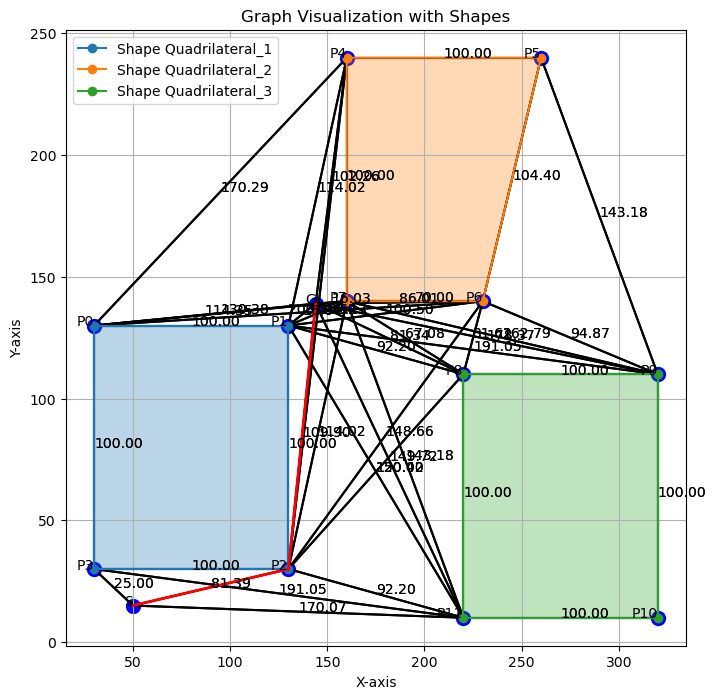

In [35]:
import matplotlib.pyplot as plt

def plot_graph_with_shapes(adjacent_list, point_names, distances, shortest_path, object_edges):
    plt.figure(figsize=(8, 8))

    # Plotting all points and their names
    for point, coordinates in point_names.items():
        plt.scatter(coordinates[0], coordinates[1], color='blue', s=100)
        plt.text(coordinates[0], coordinates[1], point, ha='right')

    # Plotting edges with distances
    for start_point, connected_points in adjacent_list.items():
        for end_point in connected_points:
            if (start_point, end_point) in distances:
                distance = distances[(start_point, end_point)]
                start_coord = point_names[start_point]
                end_coord = point_names[end_point]
                plt.plot([start_coord[0], end_coord[0]], [start_coord[1], end_coord[1]], 'k-')
                plt.text((start_coord[0] + end_coord[0]) / 2, (start_coord[1] + end_coord[1]) / 2, f'{distance:.2f}', color='black')

    # Plotting shapes
    for obj_id, points in object_edges.items():
        if isinstance(points, list):
            # Edge points: List of tuples
            x_values = [point[0] for point in points]
            y_values = [point[1] for point in points]

            # Check if the first and last points are the same to close the shape
            if points[0] != points[-1]:
                points.append(points[0])  # Append the first point at the end to close the shape

            # Update x and y values after closing the shape
            x_values = [point[0] for point in points]
            y_values = [point[1] for point in points]

            # Plot the points representing the edges of the object
            plt.plot(x_values, y_values, label=f'Shape {obj_id}', marker='o')

            # Fill the shape defined by the points for each object
            plt.fill(x_values, y_values, alpha=0.3)
        
    # Highlighting shortest path in red
    for i in range(len(shortest_path) - 1):
        start_point = point_names[shortest_path[i]]
        end_point = point_names[shortest_path[i + 1]]
        plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], 'r-', linewidth=2)


    # Set plot labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Graph Visualization with Shapes')

    # Add legend
    plt.legend()

    # Show grid
    plt.grid(True)

    # Show plot
    plt.show()
    
plot_graph_with_shapes(adjacent_list, points_name2coord, distances, shortest_path, expended_corners)